<a href="https://colab.research.google.com/github/fer-haac/examples/blob/master/ReinforcementLearning_DQN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


DQN Notebook created by [Víctor Campos](https://imatge.upc.edu/web/people/victor-campos) for UPC ETSETB AAL 2019

Updates:

[Xavier Giró](https://imatge.upc.edu/web/people/xavier-giro) - UPC ETSETB AAL 2019

[Jordi Luque](http://http://www.tid.es/research/researchers/jordi-luque) - Telefónica Research / UPC Computer Science 2020


In [0]:
# Lunch this cell code everytime you lost ssh access to the colab server 
# It usually could happen if you stop a cell in the middle of a execution)

# Preparing ssh and user in server
# Generate root password
import random, string
password ="olakase" #set password 

#''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
! sleep 2
#Get public address
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Copy authtoken from https://dashboard.ngrok.com/auth
··········
Root password: olakase
tcp://0.tcp.ngrok.io:15008


In [0]:
# if you wanna mount your own google drive
from google.colab import drive
drive.mount('/content/drive') 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# DQN example in PyTorch

This notebook is adapted from the [official DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html). Unlike the tutorial, we will use the standard observation instead of the RGB images.

In [0]:
#@title Train/eval selection
#@markdown Sometimes the notebook will crash when running an evaluation rollout (with render=True) after training. If this happens, you can skip training and load a pre-trained model with the checkboxes below.

train_model = True #@param {type:"boolean"}
load_model = False #@param {type:"boolean"}


## Installing dependencies

We will use OpenAI Gym to simulate the environment, which might not be installed by default. We also need to install some dependencies for visualization purposes (this may take a while).

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Setting up the environment

We will need some tricks to visualize the simulations in the browser, as simply calling env.render() will not work in this notebook ([source](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=Jyb2Ujuozfi2&forceEdit=true&offline=true&sandboxMode=true)).

In [0]:
import os
import gym
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple

In [0]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only


In [0]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
print('PyTorch version: ', torch.__version__)
print('Using GPU:', ['no', 'yes'][int(torch.cuda.is_available())])

PyTorch version:  1.5.0+cu101
Using GPU: yes


# For Monitor stats and video playing

Maybe needs to re-execute every time some episode crashes


In [0]:
#!apt-get install x11-utils
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [0]:
def show_video():
  !pwd
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Pacman!

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1


     |████████████████████████████████| 583kB 6.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 46.4.0
    Uninstalling setuptools-46.4.0:
      Successfully uninstalled setuptools-46.4.0


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
env = wrap_env(gym.make("MsPacman-v0"))

In [0]:
#check out the pacman action space!
print(env.action_space)

Discrete(9)


In [0]:

observation = env.reset()

for i_episode in range(1):
    observation = env.reset()
    while True:
      
        env.render()
        
        #your agent goes here
        action = env.action_space.sample() 
            
        observation, reward, done, info = env.step(action) 
      
            
        if done: 
          break;
            
env.close()
show_video()

/content


## Frozen Lake Environment

A grid represented by a matrix of characters. Their meaning is as follows:

* **S**: initial state

* **F**: frozen lake

* **H**: hole

* **G**: the goal

* **Red square**: indicates the current position of the player

In [0]:
# Let's generate a random trajectory...
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
# Choose the Cart-Pole environment from the OpenAI Gym
env = wrap_env(gym.make("FrozenLake-v0"))
env.reset()                    
env.render()




SFFF
FHFH
FFFH
HFFG


Besides, these objects offer some utility methods, like the sample() method which returns a random value from the space. With this method, we can easily create a dummy agent that plays the game randomly:

In [0]:
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

Action space:  Discrete(4)
Observation space:  Discrete(16)


In [0]:
import gym
 
MAX_ITERATIONS = 10
 
env = gym.make("FrozenLake-v0")
env.reset()
env.render()
for i in range(MAX_ITERATIONS):
    random_action = env.action_space.sample()
    new_state, reward, done, info = env.step(random_action)
    env.render()
    if done:
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


## Stochastic vs Deterministic

Note in the previous output the cases in which the player moves in a different direction than the one chosen by the agent. This behavior is completely normal in the Frozen Lake environment because it simulates a slippery surface. Also, this behavior represents an important characteristic of real-world environments: the transitions from one state to another, for a given action, are probabilistic.

By default, the Frozen Lake environment provided in Gym has probabilistic transitions between states. In other words, even when our agent chooses to move in one direction, the environment can execute a movement in another direction.

In next code, we can observe different results and paths at each execution. Also, using the info object returned by the step method we can inspect the probability used by the environment to choose the executed movement. The character moved in directions other than the selected one, with probability of 0.3333:


In [0]:
import gym
 
actions = {
    'Left': 0,
    'Down': 1,
    'Right': 2, 
    'Up': 3
}
 
print('---- winning sequence ------ ')
winning_sequence = (2 * ['Right']) + (3 * ['Down']) + ['Right']
print(winning_sequence)
 
env = gym.make("FrozenLake-v0")
#env = gym.make("FrozenLake-v0", is_slippery=False)
env.reset()
env.render()
 
for a in winning_sequence:
    new_state, reward, done, info = env.step(actions[a])
    print()
    env.render()
    print("Reward: {:.2f}".format(reward))
    print(info)
    if done:
        break  
 
print()


---- winning sequence ------ 
['Right', 'Right', 'Down', 'Down', 'Down', 'Right']

SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333}

  (Right)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333}

  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333}

  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333}

  (Down)
SFFF
FHFH
FFFH
HFFG
Reward: 0.00
{'prob': 0.3333333333333333}



However, the Frozen Lake environment can also be used in deterministic mode. By setting the property **is_slippery=False** when creating the environment, the slippery surface is turned off and then the environment always executes the action chosen by the agent




 ## Cart Pole problem and DQN solving

Here’s a bare minimum example of getting something running. This will run an instance of the CartPole-v1 environment for 1000 timesteps, rendering the environment at each step. You should see a window pop up rendering the classic cart-pole problem. It runs for 100 episodes, if any goes beyond 50 steps we stop and show the video:
*italicized text*



In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
env = wrap_env(gym.make('CartPole-v1'))

In [0]:
for i_episode in range(100):
    observation = env.reset()
    done = False
    for t in range(1000):
        env.render()
        action = env.action_space.sample() # take a random action
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    if t+1 > 50:
        print("Episode finished after {} timesteps".format(t+1))
        break    
env.close()
# ... and visualize it!
show_video()

Episode finished after 13 timesteps
Episode finished after 11 timesteps
Episode finished after 15 timesteps
Episode finished after 14 timesteps
Episode finished after 16 timesteps
Episode finished after 15 timesteps
Episode finished after 12 timesteps
Episode finished after 23 timesteps
Episode finished after 10 timesteps
Episode finished after 38 timesteps
Episode finished after 16 timesteps
Episode finished after 36 timesteps
Episode finished after 57 timesteps
Episode finished after 57 timesteps
/content


## Visualize a random policy in the environment

Our goal is to train an agent that is capable of solving the CartPole problem, where a pole is attached to a cart moving along a horizontal track. The agent can interact with the environment by applying a force (+1/-1) to the cart. The episode is terminated whenever the pole is more than 15 degrees from vertical or the cart goes out of bounds in the horizontal axis. The agent receives +1 reward for each timestep under the desired conditions.

**Exercise #1.** Visualize a rollout of a random agent in the [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) environment. Use the [documentation](http://gym.openai.com/docs/) for OpenAI Gym as a reference.

In [0]:
# Let's generate a random trajectory...
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
# Choose the Cart-Pole environment from the OpenAI Gym
env = wrap_env(gym.make("CartPole-v1"))


In [0]:
# TODO: reset the environment
ob = env.reset()

# Initialize the variables done (breaks loop) and total_rew (reward)
done = False
total_rew = 0

# Execution loop
while not done:
  env.render()
  
  # TODO: Sample a random action from the environment
  ac = env.reset()
  
  # TODO: Obtain the new state, reward and whether the episode has terminated
  ob, rew, done, info = env.reset()
  
  # Accumulate the reward
  total_rew += rew
  
print('Cumulative reward:', total_rew)
  
# ... and visualize it!
env.close()
show_video()

Cumulative reward: 0.014635979576101604
/content


## Visualize a random policy in the environment

Our goal is to train an agent that is capable of solving the CartPole problem, where a pole is attached to a cart moving along a horizontal track. The agent can interact with the environment by applying a force (+1/-1) to the cart. The episode is terminated whenever the pole is more than 15 degrees from vertical or the cart goes out of bounds in the horizontal axis. The agent receives +1 reward for each timestep under the desired conditions.

**SOLUTION Exercise #1.** Visualize a rollout of a random agent in the [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) environment. Use the [documentation](http://gym.openai.com/docs/) for OpenAI Gym as a reference.

In [0]:
# Let's generate a random trajectory...
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
# Choose the Cart-Pole environment from the OpenAI Gym
env = wrap_env(gym.make("CartPole-v1"))

In [0]:
# Initialize the variables ob (observation=state), done (breaks loop) 
# and total_rew (reward)
ob, done, total_rew = env.reset(), False, 0

# Execution loop
while not done:
  env.render()
  
  # Sample a random action from the environment
  ac = env.action_space.sample()
  
  # Obtain the new state, reward and whether the episode has terminated
  ob, rew, done, info = env.step(ac)
  
  # Accumulate the reward
  total_rew += rew
  
print('Cumulative reward:', total_rew)
  
# ... and visualize it!
env.close()
show_video()

Cumulative reward: 28.0
/content


## Create the model

Now we will define our policy, parameterized by a feedforward neural network.

**Exercise #2.** Complete the forward method of a [neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) by composing the two linear layer of perceptrons with a ReLU activation in between.

In [0]:
class DQN(nn.Module):
    def __init__(self, inputs, outputs, hidden_size=128):
        super(DQN, self).__init__()
        self.affine1 = nn.Linear(inputs, hidden_size)
        self.affine2 = nn.Linear(hidden_size, outputs)

    # TODO: Define the operations in the forward pass. 
    # NOTE: The backward function is automatically defined by PyTorch.
    def forward(self, x):
        x = self.TODO
        x = F.relu(x)
        x = self.TODO
        return x

## Create the model

Now we will define our policy, parameterized by a feedforward neural network.

**SOLUTION** **Exercise #2.** Complete the forward method of a [neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) by composing the two linear layer of perceptrons with a ReLU activation in between.

In [0]:
class DQN(nn.Module):
    def __init__(self, inputs, outputs, hidden_size=128):
        super(DQN, self).__init__()
        self.affine1 = nn.Linear(inputs, hidden_size)
        self.affine2 = nn.Linear(hidden_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.affine1(x) # AN AFFINE (LINEAR) OPERATION --> y = Wx + b DO U REMEMBER IT FROM SLIDES???
        x = F.relu(x)
        x = self.affine2(x)
        return x

## Replay memory

The buffer will be a FIFO queue: when full, oldest experiences are removed to make room for new transitions.

**Exercise #3.** Implement the pointer to the next position to be filled in the replay memory, which corresponds to a FIFO queue.
(TIP: remember the [modulus % operator](https://python-reference.readthedocs.io/en/latest/docs/operators/modulus.html)).

In [0]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        # TODO: Update the pointer to the next position in the replay memory
        self.position = TODO

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Replay memory

The buffer will be a FIFO queue: when full, oldest experiences are removed to make room for new transitions.

**SOLUTION Exercise #3.** Implement the pointer to the next position to be filled in the replay memory, which corresponds to a FIFO queue.
(TIP: remember the [modulus % operator](https://python-reference.readthedocs.io/en/latest/docs/operators/modulus.html)).

In [0]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity ## WE NEED TO CREATE A CIRCULAR BUFFER USING % MOD FUNCTION

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
        

## Functions for collecting experience and updating the policy

**Exercise #4.** Complete eps_greedy policy to facilitate the exploration.

**Exercise #5.** Complete with `policy_net` or `target_net` the `TODO_net` in the code.


In [0]:
def compute_eps_threshold(step, eps_start, eps_end, eps_decay):
  return eps_end + (eps_start - eps_end) * math.exp(-1. * step / eps_decay)


def select_action(policy, state, eps_greedy_threshold, n_actions):
    # TODO: Select action using an epsilon-greedy strategy
    if random.random() > TODO:
      with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy(state).max(1)[1].view(1, 1)
    else:
      action = torch.tensor(
          [[random.randrange(n_actions)]], device=device, dtype=torch.long)
    return action

    
def train(policy_net, target_net, optimizer, memory, batch_size, gamma):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool)
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t) for all a, then we select 
    # the columns of actions taken. These are the actions which would've been 
    # taken for each batch state according to policy_net
    state_action_values = TODO_net(state_batch).gather(1, action_batch)

    # Compute Q(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Note the call to detach() on Q(s_{t+1}), which prevents gradient flow
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = TODO_net(
        non_final_next_states).max(1)[0].detach()
    # Compute targets for Q values: y_t = r_t + max(Q_{t+1})
    expected_state_action_values = reward_batch + (next_state_values * gamma) 

    # Compute Huber loss between predicted Q values and targets y
    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1))

    # Take an SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
def test(env, policy, render=False):
    state, ep_reward, done = env.reset(), 0, False
    while not done:
        if render:
          env.render()
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = select_action(policy_net, state, 0., 1)
        state, reward, done, _ = env.step(action.item())
        ep_reward += reward
    return ep_reward

## Functions for collecting experience and updating the policy

**SOLUTION Exercise #4.** Complete eps_greedy policy to facilitate the exploration. 

**SOLUTION Exercise #5.** Complete with `policy_net` or `target_net` the `TODO_net` in the code. 


In [0]:
def compute_eps_threshold(step, eps_start, eps_end, eps_decay):
  return eps_end + (eps_start - eps_end) * math.exp(-1. * step / eps_decay)


def select_action(policy, state, eps_greedy_threshold, n_actions):
    # Select action using an epsilon-greedy strategy
    if random.random() > eps_greedy_threshold:
      with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            
            action = policy(state).max(1)[1].view(1,1)
            
    else:
      action = torch.tensor(
          [[random.randrange(n_actions)]], device=device, dtype=torch.long)
    return action

    
def train(policy_net, target_net, optimizer, memory, batch_size, gamma):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool)
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t) for all a, then we select 
    # the columns of actions taken. These are the actions which would've been 
    # taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute Q(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Note the call to detach() on Q(s_{t+1}), which prevents gradient flow
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(
        non_final_next_states).max(1)[0].detach()
    # Compute targets for Q values: y_t = r_t + max(Q_{t+1})
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss between predicted Q values and targets y
    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1))

    # Take an SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
def test(env, policy, render=False):
    state, ep_reward, done = env.reset(), 0, False
    while not done:
        if render:
          env.render()
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = select_action(policy_net, state, 0., 1)
        state, reward, done, _ = env.step(action.item())
        ep_reward += reward
    return ep_reward

## Training the agent
**Exercise #6.** Complete the call to `memory_push`.

In [0]:
# Hyperparameters
env_name = 'CartPole-v1'
gamma = 0.99  # discount factor
seed = 543  # random seed
log_interval = 25  # controls how often we log progress, in episodes
num_steps = 5e4  # number of steps to train on
batch_size = 256  # batch size for optimization
lr = 1e-4  # learning rate
eps_start = 1.0  # initial value for epsilon (in epsilon-greedy)
eps_end = 0.1  # final value for epsilon (in epsilon-greedy)
eps_decay = num_steps  # length of epsilon decay, in env steps
target_update = 1000  # how often to update target net, in env steps

In [0]:
# The default reward is +1 for any (s,a) pair. We can make the task easier
# by giving a negative reward (e.g. -10) when the pole falls.
# You can try modifying/removing this reward shaping and see what happens.
# This is a clear example of the importance of reward in RL.
def reward_shaper(rew, done):
  return rew if not done else -10.

In [0]:
# Create environment
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(env_name)

# Fix random seed (for reproducibility)
env.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [0]:
# Get number of actions from gym action space
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n

In [0]:
if train_model:
  policy_net = DQN(n_inputs, n_actions).to(device)
  target_net = DQN(n_inputs, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())
  target_net.eval()

  optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
  memory = ReplayMemory(10000)

  print("Target reward: {}".format(env.spec.reward_threshold))
  step_count = 0
  ep_rew_history = []
  i_episode, ep_reward = 0, -float('inf')
  while step_count < num_steps:
      # Initialize the environment and state
      state, done = env.reset(), False
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      while not done:
          # Select an action
          eps_greedy_threshold = compute_eps_threshold(
              step_count, eps_start, eps_end, eps_decay)
          action = select_action(
              policy_net, state, eps_greedy_threshold, n_actions)

          # Perform action in env
          next_state, reward, done, _ = env.step(action.item())

          # Bookkeeping
          next_state = torch.from_numpy(
              next_state).float().unsqueeze(0).to(device)
          reward = reward_shaper(reward, done)
          reward = torch.tensor([reward], device=device)
          step_count += 1

          # TODO: Store the transition in memory
          memory.push(TODO)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          train(policy_net, target_net, optimizer, memory, batch_size, gamma)
          
          # Update the target network, copying all weights and biases in DQN
          if step_count % target_update == 0:
              target_net.load_state_dict(policy_net.state_dict())

      i_episode += 1

      # Evaluate greedy policy
      if i_episode % log_interval == 0 or step_count >= num_steps:
          ep_reward = test(env, policy_net)
          ep_rew_history.append((i_episode, ep_reward))
          print('Episode {}\tSteps: {:.2f}k'
                '\tEval reward: {:.2f}'.format(
                i_episode, step_count/1000., ep_reward))

  print("Finished training! Eval reward: {:.2f}".format(ep_reward))
  if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
  torch.save(policy_net.state_dict(), 'checkpoints/dqn-{}.pt'.format(env_name))

## Training the agent
**SOLUTION Exercise #6.** Complete the call to `memory_push`.

In [0]:
#train_model = True

if train_model:
  policy_net = DQN(n_inputs, n_actions).to(device)
  target_net = DQN(n_inputs, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())
  target_net.eval()

  optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
  memory = ReplayMemory(10000)

  print("Target reward: {}".format(env.spec.reward_threshold))
  step_count = 0
  ep_rew_history = []
  i_episode, ep_reward = 0, -float('inf')
  while step_count < num_steps:
      # Initialize the environment and state
      state, done = env.reset(), False
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      while not done:
          # Select an action
          eps_greedy_threshold = compute_eps_threshold(
              step_count, eps_start, eps_end, eps_decay)
          action = select_action(
              policy_net, state, eps_greedy_threshold, n_actions)

          # Perform action in env
          next_state, reward, done, _ = env.step(action.item())

          # Bookkeeping
          next_state = torch.from_numpy(
              next_state).float().unsqueeze(0).to(device)
          reward = reward_shaper(reward, done)
          reward = torch.tensor([reward], device=device)
          step_count += 1

          # Store the transition in memory
          memory.push(state, action, next_state, reward) ## THE MEMORY!!

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          train(policy_net, target_net, optimizer, memory, batch_size, gamma)
          
          # Update the target network, copying all weights and biases in DQN
          if step_count % target_update == 0:
              target_net.load_state_dict(policy_net.state_dict())

      i_episode += 1

      # Evaluate greedy policy
      if i_episode % log_interval == 0 or step_count >= num_steps:
          ep_reward = test(env, policy_net)
          ep_rew_history.append((i_episode, ep_reward))
          print('Episode {}\tSteps: {:.2f}k'
                '\tEval reward: {:.2f}'.format(
                i_episode, step_count/1000., ep_reward))

  print("Finished training! Eval reward: {:.2f}".format(ep_reward))
  if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
  torch.save(policy_net.state_dict(), 'checkpoints/dqn-{}.pt'.format(env_name))

Target reward: 475.0
Episode 25	Steps: 0.60k	Eval reward: 10.00
Episode 50	Steps: 1.17k	Eval reward: 11.00
Episode 75	Steps: 1.72k	Eval reward: 9.00
Episode 100	Steps: 2.28k	Eval reward: 10.00
Episode 125	Steps: 2.75k	Eval reward: 10.00
Episode 150	Steps: 3.35k	Eval reward: 10.00
Episode 175	Steps: 3.91k	Eval reward: 9.00
Episode 200	Steps: 4.45k	Eval reward: 20.00
Episode 225	Steps: 5.03k	Eval reward: 41.00
Episode 250	Steps: 5.66k	Eval reward: 58.00
Episode 275	Steps: 6.48k	Eval reward: 139.00
Episode 300	Steps: 7.37k	Eval reward: 146.00
Episode 325	Steps: 8.01k	Eval reward: 209.00
Episode 350	Steps: 8.90k	Eval reward: 115.00
Episode 375	Steps: 9.79k	Eval reward: 98.00
Episode 400	Steps: 10.57k	Eval reward: 143.00
Episode 425	Steps: 11.33k	Eval reward: 127.00
Episode 450	Steps: 12.28k	Eval reward: 111.00
Episode 475	Steps: 13.18k	Eval reward: 142.00
Episode 500	Steps: 14.17k	Eval reward: 162.00
Episode 525	Steps: 15.31k	Eval reward: 150.00
Episode 550	Steps: 16.10k	Eval reward: 162.0

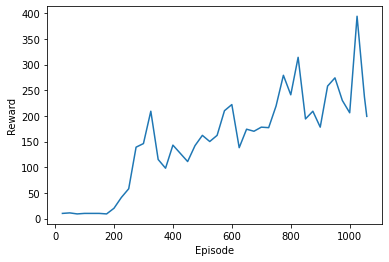

In [0]:
if train_model:
  plt.plot([x[0] for x in ep_rew_history], [x[1] for x in ep_rew_history])
  plt.xlabel('Episode')
  plt.ylabel('Reward')

## Visualize trained policy

In [0]:
load_model = True
if load_model:
  policy_net = DQN(n_inputs, n_actions).to(device)
  policy_net.load_state_dict(
      torch.load('checkpoints/dqn-{}.pt'.format(env_name)))
test_env = wrap_env(gym.make(env_name))
ep_reward = test(test_env, policy_net, render=True)
print("Cumulative reward: {}".format(ep_reward))

test_env.close()
show_video()

Cumulative reward: 215.0
/content
